In [1]:
## Libraries used
## for getting smiles
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Descriptors import rdMolDescriptors
from rdkit.Chem.Draw import MolToImage
from rdkit.Chem import MolFromSmiles
import time
import pubchempy as pcp

## making matrix
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import pandas as pd

## analysing the matrix 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
## get list of smiles of repo
# Set the API key
pcp.api_key = "17a4935adfc7ad19d0d6b7060db191df1409"

# Specify the PubChem CIDs of the compounds you want to retrieve
repo_pubchem_ids = [448281, 159772, 19910, 11857239, 121304016, 492405, 24941262, 2130, 3961, 65999, 131411, 5284360, 5071, 2719, 3652, 44205240, 6167, 3117, 3194, 10621, 3035728, 4413, 92727, 392622, 213039, 25151504, 515964, 6440352, 123985, 146025593, 37542, 45375808, 145996610, 644241, 441243, 54682461, 148195, 23649154, 24873435, 54708673, 10206, 121304016, 492405, 76853649, 54670067, 5280793, 5280795, 6321424, 447043, 772, 6741, 10364, 45358157, 485707]
## tripeptide: 16760365

allium_pubchem_ids=[31256, 11617, 62434, 525331, 16590, 5352907, 5352855, 61926, 525328, 133337, 7439, 16315, 525330, 5352694, 5352693, 521863, 75552, 121922, 65036, 9881148, 5386591, 5281112, 9578071, 12305353, 11193907, 25203227]


chunk_size = 1
 
# Set the delay time in seconds
delay = 20

# Initialize lists to track the retrieved compounds and the CIDs that could not be retrieved
compounds = []
not_retrieved = []

# Retrieve the compound objects from the PubChem database one by one
for cid in repo_pubchem_ids:
    success = False
    while not success:
        try:
            compound = pcp.Compound.from_cid(cid)
            compounds.append(compound)
            success = True
        except pcp.PubChemHTTPError as e:
            if isinstance(e, pcp.NotFoundError):
                not_retrieved.append(cid)
                success = True
            elif isinstance(e, pcp.RateLimitError):  # rate limit reached
                print("Rate limit reached, waiting...")
                time.sleep(delay)
            else:
                raise e

# Get the names and SMILES strings for the compounds and save them in a dictionary
repodrugs = {}
for compound in compounds:
    drug_name = compound.synonyms[0] if compound.synonyms else None
    repodrugs[drug_name] = compound.isomeric_smiles

# Print a message for the CIDs that could not be retrieved
if not_retrieved:
    print(f"The following CIDs could not be retrieved: {not_retrieved}")


In [3]:
## add manually tripeptie that has not synonymous in pubmed
repodrugs["tripeptide"] = "CSCC(C(=O)NC(CCCN=C(N)N)C(=O)NC(CC1=CC=CC=C1)C(=O)NCCC2=CC=CC=C2)NC(=O)CC3=CC=C(C=C3)C4=CC=CC=C4"
repodrugs["compound10"] = "C1(=CC(=CC=C1C(=O)N(CC2=CC=CC(=C2)C(=O)N(C#N)COCC3=CC=CC(=C3)C(O)=O))F)F"

In [4]:
## get list of smiles of allium
## cid numbers are defined in previous cell
chunk_size = 1
 
# Set the delay time in seconds
delay = 20

# Initialize lists to track the retrieved compounds and the CIDs that could not be retrieved
compounds = []
not_retrieved = []

# Retrieve the compound objects from the PubChem database one by one
for cid in allium_pubchem_ids:
    success = False
    while not success:
        try:
            compound = pcp.Compound.from_cid(cid)
            compounds.append(compound)
            success = True
        except pcp.PubChemHTTPError as e:
            if isinstance(e, pcp.NotFoundError):
                not_retrieved.append(cid)
                success = True
            elif isinstance(e, pcp.RateLimitError):  # rate limit reached
                print("Rate limit reached, waiting...")
                time.sleep(delay)
            else:
                raise e

# Get the names and SMILES strings for the compounds and save them in a dictionary
alliumdrugs = {}
for compound in compounds:
    drug_name = compound.synonyms[0] if compound.synonyms else None
    alliumdrugs[drug_name] = compound.isomeric_smiles

# Print a message for the CIDs that could not be retrieved
if not_retrieved:
    print(f"The following CIDs could not be retrieved: {not_retrieved}")


In [5]:
##merge both sets[repo + allium]
pool=dict(repodrugs,**alliumdrugs)
len(pool)

80

In [6]:
## why to use DICE coefficient?
'''In chemoinformatics, the Jaccard index and Dice coefficient 
are both measures of similarity between sets of molecular fingerprints. 

The Jaccard index is the size of the intersection of two sets divided by 
the size of the union of the two sets, while the Dice coefficient is 
twice the size of the intersection divided by the sum of the sizes of the two sets.

 Both measures range from 0 (no similarity) to 1 (identical sets), 
 but the Dice coefficient tends to give higher values for more similar sets. 
 
 Both are commonly used in virtual screening, clustering and other applications
 where molecular similarity is important.'''

'''The Jaccard index is typically used when the focus is on the unique elements
in each set, and the proportion of those elements that overlap between the sets. 
This can be useful when comparing sets with a high degree of diversity, 
where the presence or absence of specific elements is more important than the overall overlap.

On the other hand, the Dice coefficient is typically used when the focus is on 
the overall similarity between sets, rather than the specific elements that 
make up the sets. This can be useful when comparing sets with a high degree of similarity 
and the presence or absence of specific elements is less important than the overall overlap.'''


'''When choosing between Jaccard and Dice coefficients for clustering, it is important to consider the characteristics of the dataset. Here are a few examples:

If the dataset contains a high degree of structural diversity, the Jaccard index may be 
more appropriate, as it focuses on the unique elements in each set and the proportion of
those elements that overlap between the sets. This can help to identify distinct clusters
based on the presence or absence of specific features.

If the dataset contains a high degree of structural similarity, 
the Dice coefficient may be more appropriate, as it focuses on the 
overall similarity between sets, rather than the specific elements 
that make up the sets. This can help to group similar structures together, 
even if they have some differences in the specific features.

If the dataset contains structures with a high degree of symmetry, 
the Jaccard coefficient may be more appropriate, as it considers the presence 
and absence of specific features regardless of the order.

If the dataset contains structures with multiple conformers, 
the Dice coefficient may be more appropriate, as it tends to give higher 
similarity scores.'''

'''In addition to considering the characteristics of the dataset, 
there are a few other factors to consider when choosing between 
Jaccard and Dice coefficients for clustering:

The number of elements in each set: Jaccard index is sensitive to the size of the sets, 
whereas Dice coefficient is not. If the sets have different sizes, Jaccard index 
may not be appropriate.

The type of molecular fingerprints: Jaccard index is typically used with 
binary fingerprints, while Dice coefficient can be used with binary and 
continuous fingerprints. If the dataset uses continuous fingerprints, 
Dice coefficient might be a better choice.

The type of clustering algorithm: Some clustering algorithms such as k-means
 are sensitive to the scale of the similarity measure, while others such as 
 hierarchical clustering are not. This can affect the choice of similarity measure.

The computational cost: Jaccard index is computationally cheaper than Dice coefficient, 
as it requires fewer operations to calculate. If computational resources are limited, 
Jaccard index may be a better choice.

The interpretability of the results: Jaccard index tends to give more 
interpretable results, as it focuses on the unique elements in each set. 
Dice coefficient tends to give more similar results for more similar sets, 
but might not be as interpretable.'''

'In addition to considering the characteristics of the dataset, \nthere are a few other factors to consider when choosing between \nJaccard and Dice coefficients for clustering:\n\nThe number of elements in each set: Jaccard index is sensitive to the size of the sets, \nwhereas Dice coefficient is not. If the sets have different sizes, Jaccard index \nmay not be appropriate.\n\nThe type of molecular fingerprints: Jaccard index is typically used with \nbinary fingerprints, while Dice coefficient can be used with binary and \ncontinuous fingerprints. If the dataset uses continuous fingerprints, \nDice coefficient might be a better choice.\n\nThe type of clustering algorithm: Some clustering algorithms such as k-means\n are sensitive to the scale of the similarity measure, while others such as \n hierarchical clustering are not. This can affect the choice of similarity measure.\n\nThe computational cost: Jaccard index is computationally cheaper than Dice coefficient, \nas it requires fewe

In [7]:
## select dataset
#smiles_dict = pool #or repo or allium
smiles_dict= pool
#pool

In [8]:
## change labels according to project

## old dict is call smiles_dict [this is going to work only if complete pool]
## Create a dictionary of new labels
new_labels = {'MLN-4760': 'INH01',
 '4-GUANIDINOBENZOIC ACID': 'INH02',
 'NITROXOLINE': 'INH03',
 'tripeptide': 'INH04',
 'Narlaprevir': 'INV01',
 '1809249-37-3': 'INV02',
 'Favipiravir': 'INV03',
 'GRL0617': 'INV04',
 'amantadine': 'INV05',
 'losartan': 'RPA01',
 'Telmisartan': 'RPA02',
 'Arbidol': 'RPA03',
 'Camostat mesylate': 'RPA04',
 'rimantadine': 'RPA05',
 'chloroquine': 'RPA06',
 'hydroxychloroquine': 'RPA07',
 'Baricitinib': 'RPA08',
 'colchicine': 'RPA09',
 'disulfiram': 'RPA10',
 'ebselen': 'RPA11',
 'hesperidin': 'RPA12',
 'Qingdainone': 'RPA13',
 'Nafamostat': 'RPA14',
 'compound10': 'RPA15', 
 'Lopinavir': 'RPB01',
 'ritonavir': 'RPB02',
 'Darunavir': 'RPB03',
 'Cobicistat': 'RPB04',
 'SARS-CoV-2-IN-18': 'RPB05',
 'Rupintrivir': 'RPB06',
 'e-64': 'RPB07',
 'Inhibitor N3': 'RPB08',
 'ribavirin': 'RPC01',
 'SOFOSBUVIR': 'RPC02',
 'EIDD 2801': 'RPC03',
 'Nilotinib': 'RPC04',
 'SAQUINAVIR': 'RPC05',
 'Tipranavir': 'RPC06',
 'Lonafarnib': 'RPC07',
 'Tegobuvir': 'RPC08',
 'SIMEPREVIR': 'RPC09',
 'Filibuvir': 'RPC10',
 'CEPHARANTHINE': 'RPC11',
 'rac5c': 'RPD01',
 'ascorbic acid': 'EXT01',
 'ergocalciferol': 'EXT02',
 'Vitamin D3': 'EXT03',
 'IVERMECTIN': 'EXT04',
 'azithromycin': 'EXT05',
 'enoxaparin': 'EXT06',
 'methylprednisolone': 'EXT07',
 'CARVACROL': 'EXT08',
 'AKOS015965499': 'EXT09',
 'oleanoic acid': 'EXT10',
 'Diacetone alcohol': 'ALI01',
 'DIALLYL SULFIDE': 'ALI02',
 'ALLYL METHYL DISULFIDE': 'ALI03',
 '1,2-dithiole': 'ALI04',
 'DIALLYL DISULFIDE': 'ALI05',
 '(E)-1-Propenyl 2-propenyl disulfide': 'ALI07',
 '2-Propenyl 1-propenyl disulfide': 'ALI06',
 'ALLYL METHYL TRISULFIDE': 'ALI08',
 '3-Vinyl-1,2-dithiacyclohex-4-ene': 'ALI09',
 '2-Vinyl-4H-1,3-dithiine': 'ALI10',
 'CARVONE': 'ALI11',
 'Diallyl trisulfide': 'ALI12',
 'allyl propyl trisulfide': 'ALI13',
 'cis-1-Propenyl propyl trisulfide': 'ALI14',
 'trans-1-Propenyl propyl trisulfide': 'ALI15',
 'Methyl 1-propenyl disulfide': 'ALI16',
 'Diallyl tetrasulfide': 'ALI17',
 'Alliin': 'ALI18',
 'Allicin': 'ALI19',
 '(Z)-Ajoene': 'ALI20',
 'Ajoene': 'ALI21',
 'isoalliin': 'ALI23',
 '32726-14-0': 'ALI22',
 '455-41-4': 'ALI24',
 'N-gamma-Glutamyl-S-allylcysteine': 'ALI25',
 'gamma-Glutamyl-S-1-propenyl cysteine': 'ALI26'}

# Create a dictionary comprehension to map the old labels to the new labels
smiles_dict = {new_labels[key]: value for key, value in smiles_dict.items()}

In [9]:
smiles_dict

{'INH01': 'CC(C)C[C@@H](C(=O)O)N[C@@H](CC1=CN=CN1CC2=CC(=CC(=C2)Cl)Cl)C(=O)O',
 'INH02': 'C1=CC(=CC=C1C(=O)O)N=C(N)N',
 'INH03': 'C1=CC2=C(C=CC(=C2N=C1)O)[N+](=O)[O-]',
 'INV01': 'CCCC[C@@H](C(=O)C(=O)NC1CC1)NC(=O)[C@@H]2[C@@H]3[C@@H](C3(C)C)CN2C(=O)[C@H](C(C)(C)C)NC(=O)NC4(CCCCC4)CS(=O)(=O)C(C)(C)C',
 'INV02': 'CCC(CC)COC(=O)[C@H](C)N[P@](=O)(OC[C@@H]1[C@H]([C@H]([C@](O1)(C#N)C2=CC=C3N2N=CN=C3N)O)O)OC4=CC=CC=C4',
 'INV03': 'C1=C(N=C(C(=O)N1)C(=O)N)F',
 'INV04': 'CC1=C(C=C(C=C1)N)C(=O)N[C@H](C)C2=CC=CC3=CC=CC=C32',
 'INV05': 'C1C2CC3CC1CC(C2)(C3)N',
 'RPA01': 'CCCCC1=NC(=C(N1CC2=CC=C(C=C2)C3=CC=CC=C3C4=NNN=N4)CO)Cl',
 'RPA02': 'CCCC1=NC2=C(N1CC3=CC=C(C=C3)C4=CC=CC=C4C(=O)O)C=C(C=C2C)C5=NC6=CC=CC=C6N5C',
 'RPA03': 'CCOC(=O)C1=C(N(C2=CC(=C(C(=C21)CN(C)C)O)Br)C)CSC3=CC=CC=C3',
 'RPA04': 'CN(C)C(=O)COC(=O)CC1=CC=C(C=C1)OC(=O)C2=CC=C(C=C2)N=C(N)N.CS(=O)(=O)O',
 'RPA05': 'CC(C12CC3CC(C1)CC(C3)C2)N',
 'RPA06': 'CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl',
 'RPA07': 'CCN(CCCC(C)NC1=C2C=CC(=CC2=NC=

In [10]:
## Calculate a Dice matrix

# Create a list of RDKit fingerprints
fp_list = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2) for s in smiles_dict.values()]

# Create an empty matrix with the same number of rows and columns as the number of fingerprints
matrix = [[0 for _ in range(len(fp_list))] for _ in range(len(fp_list))]

# Fill the matrix with Tanimoto or Dice coefficients
##DiceSimilarity or TanimotoSimilarity 
for i in range(len(fp_list)):
    for j in range(i, len(fp_list)):
        matrix[i][j] = DataStructs.DiceSimilarity(fp_list[i], fp_list[j])
        matrix[j][i] = matrix[i][j]

# Get the labels from the dictionary
labels = list(smiles_dict.keys())

# Create a DataFrame from the matrix and labels
matrix = pd.DataFrame(matrix, columns=labels, index=labels)

# Print the DataFrame
matrix.to_csv('DiceMatrix.csv')

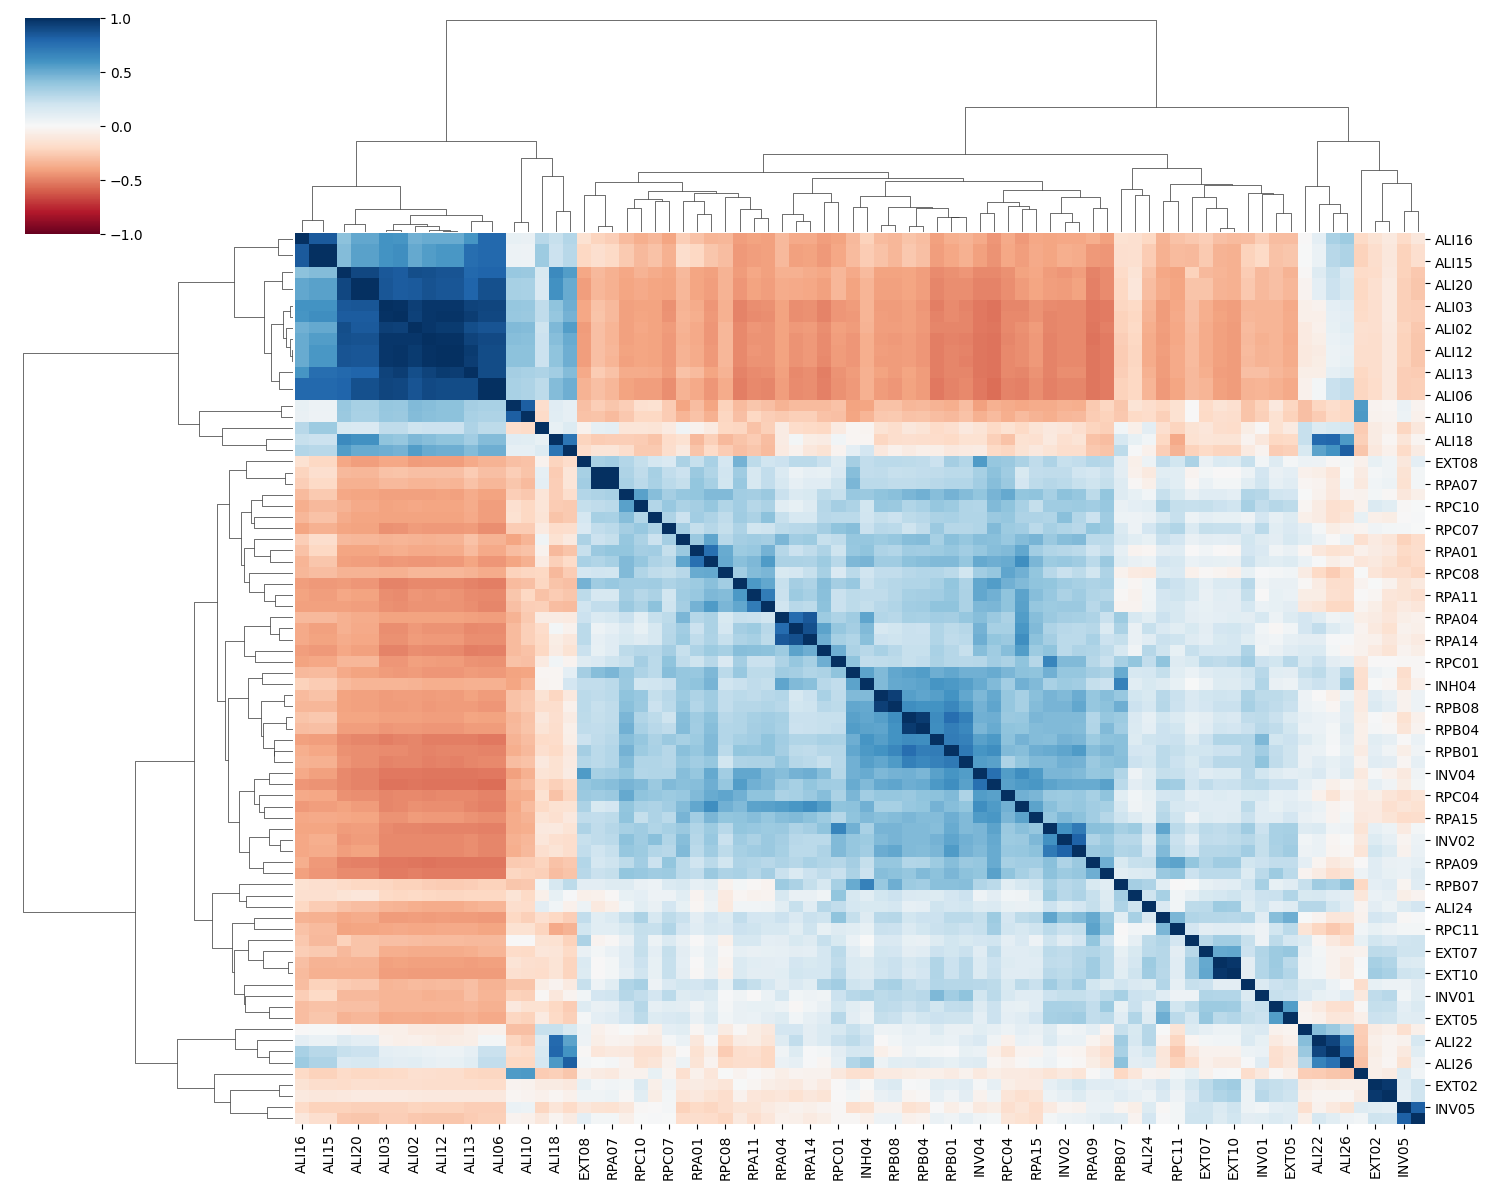

In [11]:
# Plot corralation matrix
correlations = matrix.corr()
sns.clustermap(correlations, method="complete", cmap='RdBu', annot=False,
               annot_kws={"size": 7},
               vmin=-1, vmax=1, figsize=(15, 12))


Number of clusters: 5


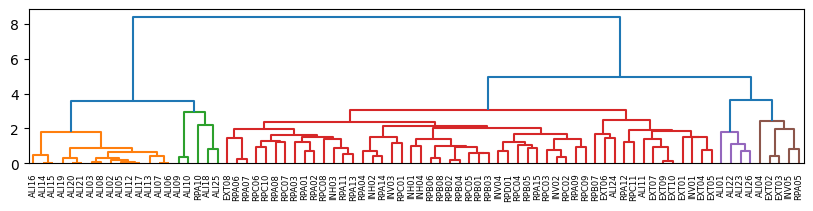

In [12]:
# How many clusters?
# Determine number of clusters using the fcluster function
Z = linkage(correlations, method="complete")
max_d = 3.1
fclusters = fcluster(Z, max_d, criterion='distance')

# Print the number of clusters
n_clusters = len(set(fclusters))
print(f'Number of clusters: {n_clusters}')
plt.figure(figsize=(10, 2))
dendrogram = dendrogram(Z, color_threshold=max_d, labels=correlations.index)


In [13]:
#PCA
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Apply PCA to the data
pca = PCA(n_components=3)
transformed_data = pca.fit_transform(correlations)

# Perform clustering on the transformed data
kmeans = KMeans(n_clusters=n_clusters)
clusters2 = kmeans.fit_predict(transformed_data)

/home/ahr/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
## PCA 3D plot
import plotly.express as px

# Create a DataFrame with the transformed data and cluster labels
df = pd.DataFrame(transformed_data, columns=['PC1', 'PC2', 'PC3'])
df['cluster'] = clusters2
df['drugs'] = correlations.index

# Create a scatter plot
px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='cluster', hover_name='drugs')

In [15]:
## make a df with compound, smiles and cluster information
smiles = pd.DataFrame.from_records(list(smiles_dict.items()), columns=['compound','smiles'])
smiles['cluster'] = list(clusters2)

In [18]:
## make dfs per cluster
dfs = {i:smiles.loc[smiles['cluster'] == i] for i in range(0, n_clusters)}

## save csv
smiles.to_csv('clusters_csvs/smiles.csv')
print('All the data is save it on: clusters_csvs/smiles.csv')

for i in dfs:
    dfs[i].to_csv('clusters_csvs/clusters_'+str(i)+'.csv')
    print('files are save it on: clusters_csvs/clusters_'+str(i)+'.csv')

All the data is save it on: clusters_csvs/smiles.csv
files are save it on: clusters_csvs/clusters_0.csv
files are save it on: clusters_csvs/clusters_1.csv
files are save it on: clusters_csvs/clusters_2.csv
files are save it on: clusters_csvs/clusters_3.csv
files are save it on: clusters_csvs/clusters_4.csv
